## Cargamos los Dataset

In [1]:
import pandas as pd
import glob
import os

def load_and_aggregate_data(path_raw):
    """
    Carga los CSVs, limpia nulos y AGRUPA por tiempo y celda
    para obtener la carga total de la red.
    """
    file_pattern = os.path.join(path_raw, "sms-call-internet-mi-*.csv")
    all_files = sorted(glob.glob(file_pattern))

    print(f"Procesando {len(all_files)} archivos...")

    df_list = []

    for filename in all_files:
        print(f" -> Leyendo {os.path.basename(filename)}")
        # parse_dates=['datetime'] le dice a pandas que lea esa columna como fecha directamente
        df_temp = pd.read_csv(filename, parse_dates=['datetime'])
        df_list.append(df_temp)

    print("Concatenando...")
    df_raw = pd.concat(df_list, ignore_index=True)

    # 1. Rellenar NaNs con 0 (Asumimos que vacío = 0 tráfico)
    cols_to_fix = ['smsin', 'smsout', 'callin', 'callout', 'internet']
    df_raw[cols_to_fix] = df_raw[cols_to_fix].fillna(0)

    # 2. Renombrar CellID a square_id para estandarizar
    df_raw.rename(columns={'CellID': 'square_id'}, inplace=True)

    # 3. AGREGACIÓN: Sumar tráfico de todos los country_codes para el mismo momento y lugar
    # Eliminamos 'countrycode' antes de agrupar porque ya no lo necesitamos
    print("Agrupando tráfico (esto puede tardar unos segundos)...")
    df_clean = df_raw.groupby(['datetime', 'square_id'])[cols_to_fix].sum().reset_index()

    return df_clean

# --- EJECUCIÓN ---
PATH_RAW = "../data/raw/"

try:
    df = load_and_aggregate_data(PATH_RAW)

    print("\n--- Resultado Final Limpio ---")
    print(df.head())
    print(f"\nDimensiones: {df.shape}")
    print(f"Rango de Fechas: {df['datetime'].min()} a {df['datetime'].max()}")
    print(f"Total Celdas Únicas: {df['square_id'].nunique()}")

except Exception as e:
    print(f"Error crítico: {e}")

Procesando 7 archivos...
 -> Leyendo sms-call-internet-mi-2013-11-01.csv
 -> Leyendo sms-call-internet-mi-2013-11-02.csv
 -> Leyendo sms-call-internet-mi-2013-11-03.csv
 -> Leyendo sms-call-internet-mi-2013-11-04.csv
 -> Leyendo sms-call-internet-mi-2013-11-05.csv
 -> Leyendo sms-call-internet-mi-2013-11-06.csv
 -> Leyendo sms-call-internet-mi-2013-11-07.csv
Concatenando...
Agrupando tráfico (esto puede tardar unos segundos)...

--- Resultado Final Limpio ---
    datetime  square_id   smsin  smsout  callin  callout  internet
0 2013-11-01          1  2.0843  1.1047  0.5919   0.4293   57.7990
1 2013-11-01          2  2.0915  1.0880  0.6020   0.4382   57.9149
2 2013-11-01          3  2.0992  1.0701  0.6128   0.4476   58.0382
3 2013-11-01          4  2.0633  1.1533  0.5627   0.4036   57.4634
4 2013-11-01          5  1.8708  1.0439  0.5110   0.3740   52.1714

Dimensiones: (1679994, 7)
Rango de Fechas: 2013-11-01 00:00:00 a 2013-11-07 23:00:00
Total Celdas Únicas: 10000


## Analisis EDA

### Visualización 1: "El Latido de la Red" (Análisis Temporal)

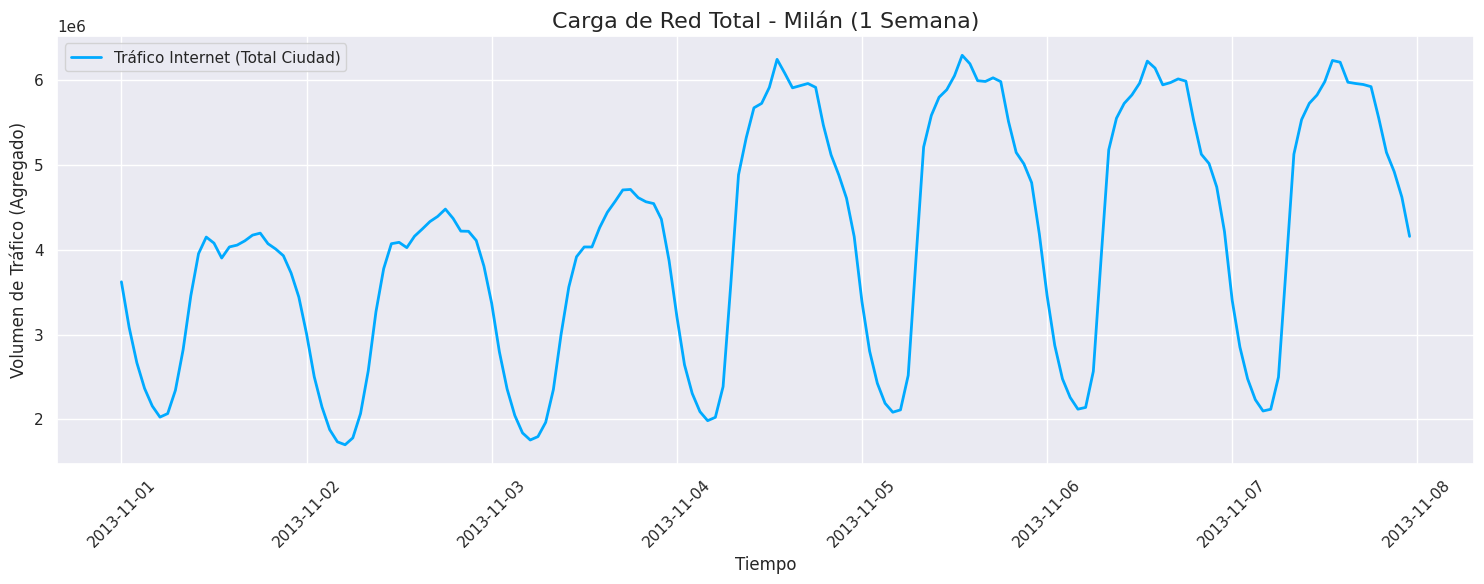

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo "Pro"
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15, 6))

# 1. Agrupamos por hora para ver el total de la ciudad
# Esto simula el tráfico total que entra al Data Center principal
df_temporal = df.groupby('datetime')['internet'].sum().reset_index()

# 2. Plotting
plt.plot(df_temporal['datetime'], df_temporal['internet'], label='Tráfico Internet (Total Ciudad)', color='#00aaff', linewidth=2)

plt.title('Carga de Red Total - Milán (1 Semana)', fontsize=16)
plt.ylabel('Volumen de Tráfico (Agregado)', fontsize=12)
plt.xlabel('Tiempo', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualización 2: "El Mapa de Calor" (Análisis Espacial)

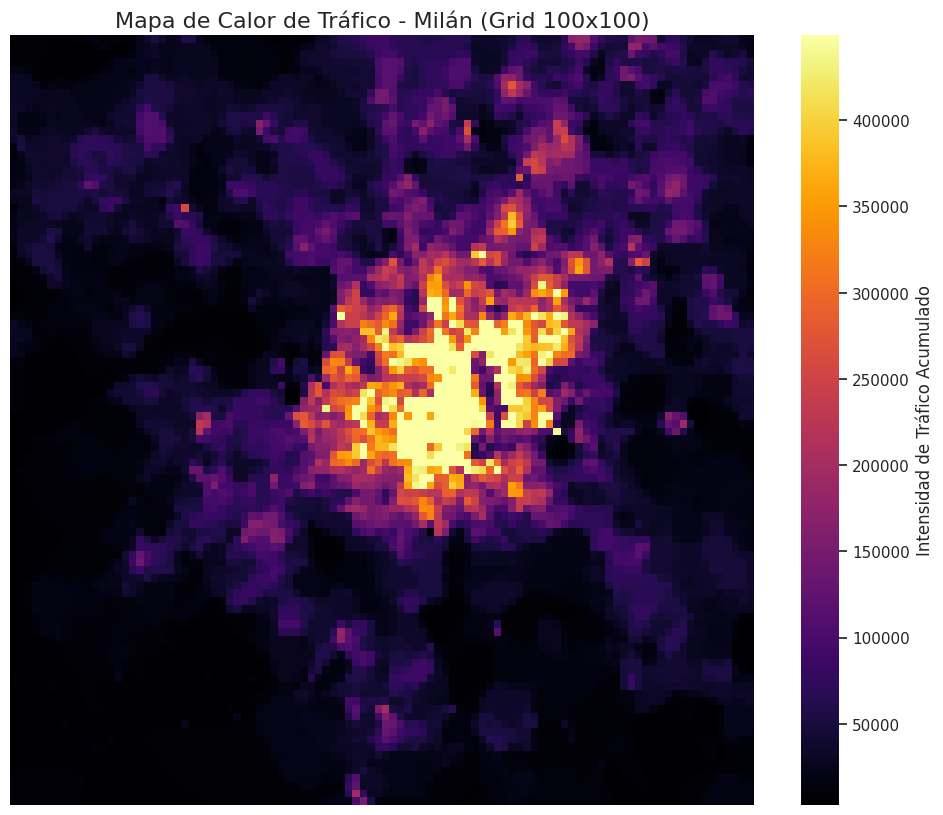

In [3]:
import numpy as np

# 1. Agrupamos por celda (sumamos todo el tráfico de la semana por zona)
df_spatial = df.groupby('square_id')['internet'].sum().reset_index()

# 2. Creamos una matriz 100x100
# Nota: Los square_id van de 1 a 10000. Los índices de array van de 0 a 9999.
# Rellenamos una matriz vacía
grid_matrix = np.zeros(10000)
# Asignamos valores (restando 1 al ID para el índice)
# Usamos un "mapa" seguro por si faltara algún ID
grid_matrix[df_spatial['square_id'] - 1] = df_spatial['internet']

# Reshape a 100x100 para visualizar
grid_matrix = grid_matrix.reshape(100, 100)

# 3. Plotting Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(grid_matrix, cmap='inferno', robust=True, cbar_kws={'label': 'Intensidad de Tráfico Acumulado'})
plt.title('Mapa de Calor de Tráfico - Milán (Grid 100x100)', fontsize=16)
# Invertimos el eje Y porque en las matrices el índice 0 está arriba
plt.gca().invert_yaxis()
plt.axis('off') # Ocultamos ejes numéricos para que parezca un mapa
plt.show()

In [4]:
# --- EXPORTACIÓN ---
# Guardamos el df en un archivo .pkl (más rápido y seguro que CSV para fechas)
df.to_pickle("df_clean.pkl")
print("Datos exportados exitosamente a 'df_clean.pkl'")

Datos exportados exitosamente a 'df_clean.pkl'
